# 1. CB22x - Ancient Greek Hero

## Set global variables

In [1]:
import os

In [2]:
CONSOLIDATED_DATA_DIR = '../processed/'
COURSE_LIST = [d[0][13:] for d in os.walk(CONSOLIDATED_DATA_DIR)][1:]

In [3]:
COURSE_LIST

['HarvardXCB22x2013_Spring',
 'HarvardXCS50x2012',
 'HarvardXER22x2013_Spring',
 'HarvardXPH207x2012_Fall',
 'HarvardXPH278x2013_Spring',
 'MITx14.73x2013_Spring',
 'MITx2.01x2013_Spring',
 'MITx3.091x2012_Fall',
 'MITx3.091x2013_Spring',
 'MITx6.002x2012_Fall',
 'MITx6.002x2013_Spring',
 'MITx6.00x2012_Fall',
 'MITx6.00x2013_Spring',
 'MITx7.00x2013_Spring',
 'MITx8.02x2013_Spring',
 'MITx8.MReV2013_Summer']

In [4]:
DATA_DIR = '../processed-final/'

## Design the feed-forward neural net

In [5]:
import pandas as pd
import numpy as np
import tensorflow as tf

C:\ProgramData\Anaconda3\lib\site-packages\h5py\__init__.py:34: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [6]:
np.random.seed(20130810)
tf.set_random_seed(20130810)

In [7]:
import plothelpers as plh

In [8]:
from keras.models import Sequential, load_model

from keras.layers import Dense, Activation, Dropout, BatchNormalization

from keras.regularizers import l2

from keras.losses import binary_crossentropy

from keras.optimizers import RMSprop, Adam

from keras.metrics import binary_accuracy

from keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint

from keras import backend as K

Using TensorFlow backend.


In [9]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score

In [10]:
def build(network_type=Sequential, 
          nb_initial_layer=64,
          dense_layer_lst=[64],
          nb_final_layer=1,
          l2_penalty=0.001,
          dpt_strength=0.5,
          learning_rate=1e-4):
    
    model = network_type()
    
    model.add(Dense(nb_initial_layer, 
                    input_shape=(features_train.shape[1],),
                    kernel_initializer='he_normal',
                    kernel_regularizer=l2(l2_penalty)))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(dpt_strength))
    
    for nb_units in dense_layer_lst:
        model.add(Dense(nb_units,
                        kernel_initializer='he_normal',
                        kernel_regularizer=l2(l2_penalty)))
        model.add(BatchNormalization())
        model.add(Activation('relu'))
        model.add(Dropout(dpt_strength))
        
    model.add(Dense(nb_final_layer,
                    kernel_initializer='he_normal',
                    kernel_regularizer=l2(l2_penalty)))
    model.add(BatchNormalization())
    model.add(Activation('sigmoid'))
    
    model.compile(optimizer=Adam(lr=learning_rate),
                  loss=binary_crossentropy,
                  metrics=[binary_accuracy])
    
    return model

## Tune the network

In [11]:
course_idx = 0
print(COURSE_LIST[course_idx])

HarvardXCB22x2013_Spring


In [12]:
course_loc = DATA_DIR + COURSE_LIST[course_idx]
print(course_loc)

../processed-final/HarvardXCB22x2013_Spring


In [13]:
features_train = pd.read_feather(course_loc + '_features_train.feather').drop('index', axis=1)
features_test = pd.read_feather(course_loc + '_features_test.feather').drop('index', axis=1)

labels_train = pd.read_feather(course_loc + '_labels_train.feather').drop('index', axis=1)
labels_test = pd.read_feather(course_loc + '_labels_test.feather').drop('index', axis=1)

In [14]:
features_train = np.array(features_train)
features_test = np.array(features_test)

labels_train = np.array(labels_train).ravel()
labels_test = np.array(labels_test).ravel()

In [15]:
features_train.shape

(24001, 18)

In [16]:
labels_train.shape

(24001,)

In [17]:
features_train, features_validation, labels_train, labels_validation = train_test_split(features_train, labels_train, 
                                                                                        test_size=0.2, 
                                                                                        random_state=20130810)

In [18]:
features_train.shape, features_validation.shape

((19200, 18), (4801, 18))

In [19]:
labels_train.shape, labels_validation.shape

((19200,), (4801,))

In [20]:
K.clear_session()

In [21]:
model = build(nb_initial_layer=32, 
              dense_layer_lst=[32, 32, 32],
              l2_penalty=0.001,
              dpt_strength=0.5,
              learning_rate=1e-3)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 32)                608       
_________________________________________________________________
batch_normalization_1 (Batch (None, 32)                128       
_________________________________________________________________
activation_1 (Activation)    (None, 32)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 32)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 32)                1056      
_________________________________________________________________
batch_normalization_2 (Batch (None, 32)                128       
_________________________________________________________________
activation_2 (Activation)    (None, 32)                0         
__________

In [22]:
# We wish to save multiple best models.
# Main purpose is to make it easier to choose the final model as we hand tune. We delete excess saved models at the end to 
# get to the best model
# This strategy would be useful if we are going to use an ensemble

out_file_path='../best-keras-runs/' + \
               COURSE_LIST[course_idx] + \
              '-8-{epoch:02d}-{val_binary_accuracy:.2f}.hdf5'

In [ ]:
# In case you wish to save only the best model
#out_file_path='best-keras-runs/' + \
#               COURSE_LIST[course_idx] + \
#              '-best-model.hdf5'

In [23]:
model_output = model.fit(features_train, labels_train,
                         batch_size=128,
                         epochs=50,
                         validation_data=[features_validation, labels_validation],
                         callbacks=[EarlyStopping(patience=4), 
                                    ReduceLROnPlateau(patience=4, min_lr=1e-6),
                                    ModelCheckpoint(out_file_path, 
                                                    monitor='val_binary_accuracy',
                                                    mode='max',
                                                    verbose=1, 
                                                    save_best_only=True, 
                                                    save_weights_only=False)])

Train on 19200 samples, validate on 4801 samples
Epoch 1/50
19200/19200 [==============================] - 2s 107us/step - loss: 0.9246 - binary_accuracy: 0.5239 - val_loss: 0.8185 - val_binary_accuracy: 0.6419

Epoch 00001: val_binary_accuracy improved from -inf to 0.64195, saving model to ../best-keras-runs/HarvardXCB22x2013_Spring-8-01-0.64.hdf5
Epoch 2/50
19200/19200 [==============================] - 1s 34us/step - loss: 0.8497 - binary_accuracy: 0.5600 - val_loss: 0.7907 - val_binary_accuracy: 0.6434

Epoch 00002: val_binary_accuracy improved from 0.64195 to 0.64341, saving model to ../best-keras-runs/HarvardXCB22x2013_Spring-8-02-0.64.hdf5
Epoch 3/50
19200/19200 [==============================] - 1s 36us/step - loss: 0.8085 - binary_accuracy: 0.5834 - val_loss: 0.7692 - val_binary_accuracy: 0.6405

Epoch 00003: val_binary_accuracy did not improve from 0.64341
Epoch 4/50
19200/19200 [==============================] - 1s 35us/step - loss: 0.7806 - binary_accuracy: 0.5989 - val_los

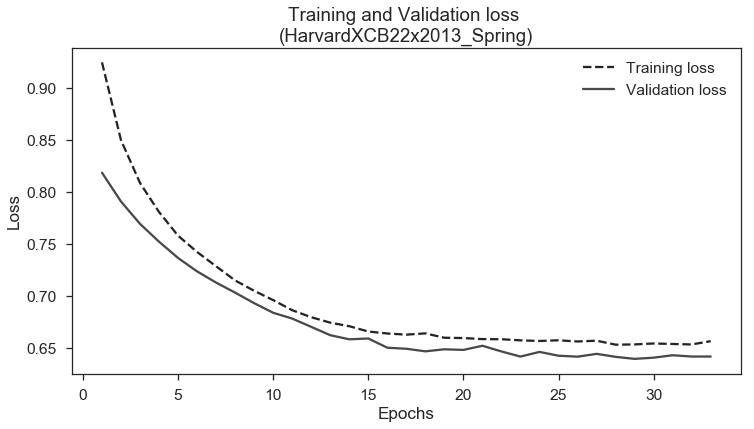

In [24]:
plh.plot_loss(model_output.history, COURSE_LIST[course_idx])

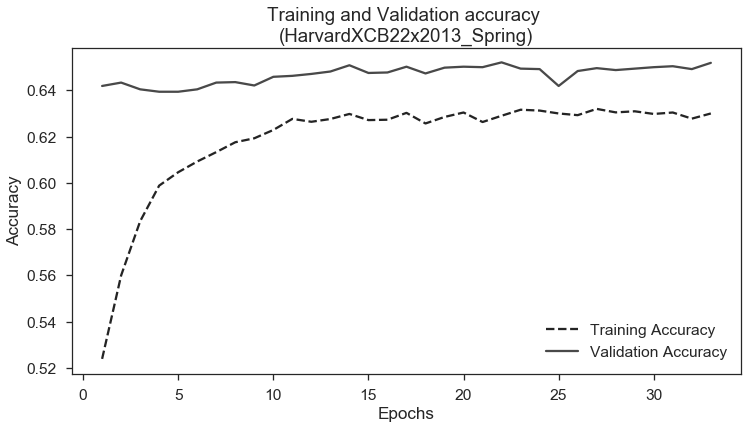

In [25]:
plh.plot_accuracy(model_output.history, COURSE_LIST[course_idx])

### Load the best model and compute metrics

In [26]:
best_model = load_model('HarvardXCB22x2013_Spring-2-37-0.66.hdf5')

#### Training data

In [27]:
best_model.evaluate(features_train, labels_train, batch_size=128)

19200/19200 [==============================] - 0s 22us/step


[0.6424851973851522, 0.64625]

In [28]:
pred_probs = best_model.predict_proba(features_train)

In [29]:
pred_probs.mean()

0.5547545

In [30]:
labels_train.mean()

0.54484375

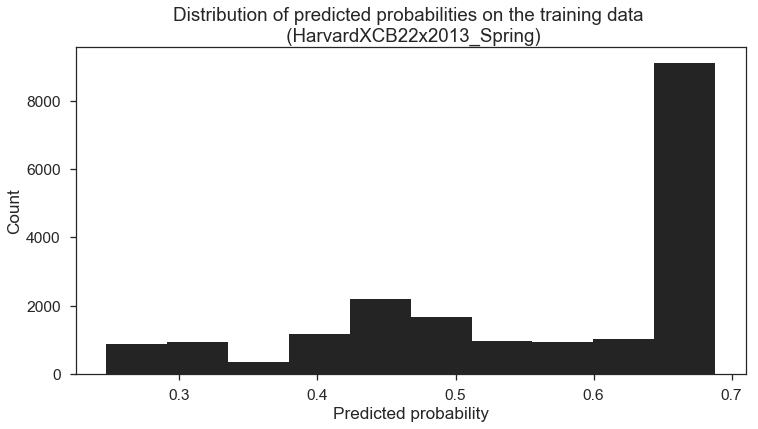

In [31]:
plh.plot_probs(pred_probs, COURSE_LIST[course_idx], data='training')

#### Validation data

In [32]:
best_model.evaluate(features_validation, labels_validation, batch_size=128)

4801/4801 [==============================] - 0s 14us/step


[0.6403871990446993, 0.6527806709791516]

In [33]:
pred_probs = best_model.predict_proba(features_validation)

In [34]:
pred_probs.mean()

0.5549327

In [35]:
labels_validation.mean()

0.5382212039158508

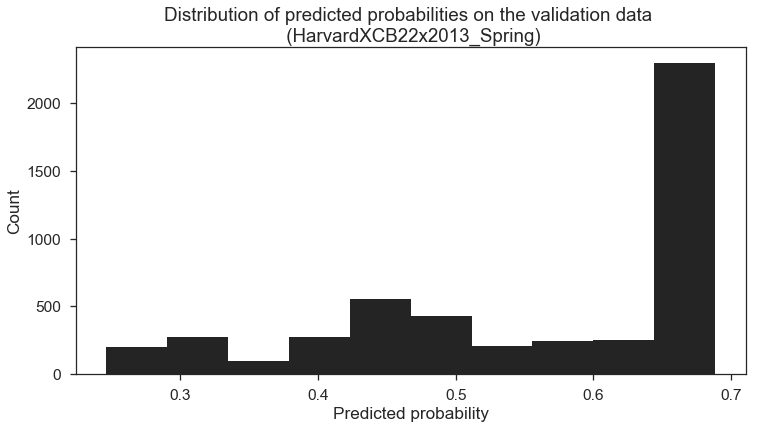

In [36]:
plh.plot_probs(pred_probs, COURSE_LIST[course_idx], data='validation')

#### Test data

In [ ]:
## DO NOT RUN THIS CELL TILL IT IS TIME TO REPORT RESULTS ON TEST DATA

# accuracy_score(best_model.predict_classes(features_test), labels_test)
# f1_score(best_model.predict_classes(features_test), labels_test)